# Feature Analysis and Genotype Classification

### Note
This notebook did not stratify samples. Accuracies may not be reflective of class distributions

## Imports

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler

sys.path.append("../utils")
import preprocess_utils as ppu

/home/camo/anaconda3/envs/nf1_analysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Seed and Generator for Reproducibility

In [2]:
rnd_val = 0  # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val)  # random number generator

# K Cross Validation

In [3]:
num_splits = 5  # Default number of splits


def kcross_val(model, feat, splits=num_splits):
    """
    Parameters
    ----------
    model: sklearn model
        The model to be trained and evaluated.
    feat : Pandas Dataframe
        The preprocessed dataframe with features and labels.
    splits: int
        The number of splits for k cross validation

    Returns
    -------
    dict
        A dictionary containing: {Best validation accuracy, Best model, Prediction of best model, Validation set labels}.
        "Best" corresponds to the greatest validation accuracy.
    """

    cv = KFold(n_splits=splits, random_state=rnd_val, shuffle=True)
    max_acc = 0  # Keep track of the maximum accuracy

    for train_idx, val_idx in cv.split(X=feat):  # iterates through index splits
        yval = feat[val_idx, -1].astype(np.int64)  # Validation labels converted to ints
        ytrain = feat[train_idx, -1].astype(
            np.int64
        )  # Training labels converted to ints
        Xval = feat[val_idx, 0:-1]  # Validation features
        Xtrain = feat[train_idx, 0:-1]  # Training features

        model.fit(Xtrain, ytrain)  # Fitting the model
        acc = model.score(Xval, yval)  # Scoring the model on the validation set

        if max_acc < acc:  # Find the model with the best validation accuracy
            max_acc, best_model, best_preds, val_labels = (
                acc,
                model,
                model.predict(Xval),
                yval,
            )

    res = {
        "acc": max_acc,
        "model": best_model,
        "preds": best_preds,
        "labels": val_labels,
    }  # Store as a dictionary

    return res

In [4]:
# Naive Model:
class naive_model:
    """
    A naive model, which chosses a random class to generate predictions.
    """

    def __init__(self):
        pass

    def score(self, labels):
        """
        Parameters
        ----------
        labels
            The genotype labels.

        Returns
        -------
        float
            A naive accuracy (baseline accuracy) for the given labels without considering any features.
        """
        naive_pred = rng.integers(low=0, high=2, size=labels.shape[0])
        naive_acc = accuracy_score(naive_pred, labels)
        return naive_acc

## Confusion Matrix

In [5]:
# Display Confusion matrix
def conf_mat(model_res, mat_title="Confusion Matrix"):
    """
    Parameters
    ----------
    model_res : dict
        A dictionary containing: Best validation accuracy, Best model, Prediction of best model, Validation set labels.
        "Best" corresponds to the greatest validation accuracy.

    mat_title: str
        The title of the confusion matrix.
    """
    cm = confusion_matrix(model_res["labels"], model_res["preds"])
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    display = ConfusionMatrixDisplay(cm, display_labels=np.unique(model_res["labels"]))
    ax.set(title=mat_title)
    display.plot(ax=ax)

# Converting csv to pandas dataframe

In [6]:
data_dir = pathlib.Path(
    "../nf1_painting_repo/3.processing_features/data/feature_selected_data/Plate_1_sc_norm_fs.parquet"
)

In [7]:
# If the file isn't found in the path above then raise an error.
if not data_dir.is_file():
    raise FileNotFoundError(f"File '{data_dir}' does not exist")

po = ppu.Preprocess_data(data_dir)
morph_feat = po.df

# Creating binary labels for the genotype

In [8]:
lb = LabelBinarizer()
morph_feat["genotype_label"] = lb.fit_transform(morph_feat["Metadata_genotype"])
featdf = morph_feat  # Create a copy for modification

# Sampling

In [9]:
def down_sample(df, samp_size):
    """
    Samples the dataframe according to the sample size.

    Parameters
    ----------
    df: Pandas Dataframe
        The dataframe to be sampled.
    samp_size
        The sample size to be sampled from each class.

    Returns
    -------
    Pandas Dataframe
        The sampled dataframe.

    """
    return df.sample(n=samp_size, random_state=rnd_val)

# Selecting Features

In [10]:
feat_col = [
    col for col in featdf.columns if "Metadata" not in col
]  # Select all columns that don't contain the Metadata in their name

featdf = featdf[feat_col]
featdf = featdf.loc[:, featdf.columns != "Unnamed: 0"]  # Remove the unnamed column

In [11]:
min_class_samps_size = min(
    featdf["genotype_label"].value_counts().values
)  # Sample size for the minority class
dsamp_featdf = featdf.groupby("genotype_label", group_keys=False).apply(
    down_sample, min_class_samps_size
)  # Down-sample features according to minority class
traindf, testdf = train_test_split(
    dsamp_featdf, random_state=rnd_val, shuffle=True, train_size=0.9
)  # Train and Test Dataframes

In [12]:
train_feat = traindf.to_numpy()
test_feat = testdf.to_numpy()

# Principle Component Analysis (PCA) Visualization

In [13]:
null_idx = np.nonzero(train_feat[:, -1] == 0)[0]
wt_idx = np.nonzero(train_feat[:, -1] != 0)[0]

Explained variance in PC1 and PC2 = 0.22793538301948318


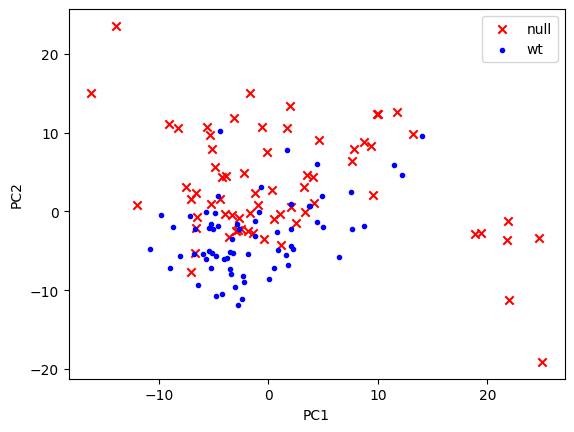

In [14]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(train_feat[:, 0:-1])
print(f"Explained variance in PC1 and PC2 = {np.sum(pca.explained_variance_ratio_)}")
null = plt.scatter(
    pca_features[null_idx, 0], pca_features[null_idx, 1], marker="x", color="r"
)
wt = plt.scatter(
    pca_features[wt_idx, 0], pca_features[wt_idx, 1], marker=".", color="b"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend((null, wt), ("null", "wt"))
plt.show()

In [15]:
reducer = umap.UMAP(random_state=rnd_val)
reducer.fit(train_feat[:, 0:-1])

UMAP(random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

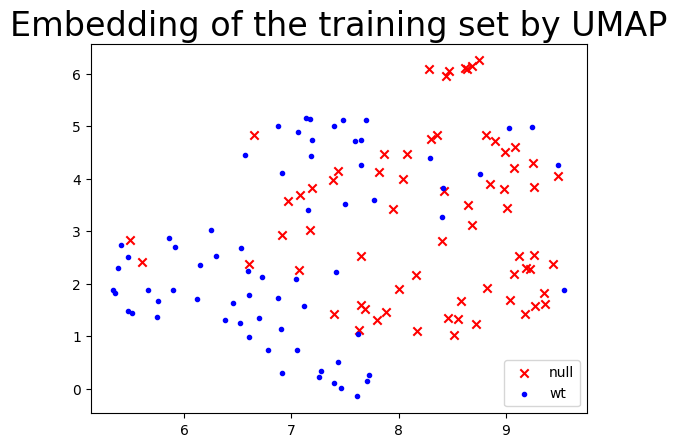

In [16]:
null = plt.scatter(
    reducer.embedding_[null_idx, 0],
    reducer.embedding_[null_idx, 1],
    marker="x",
    color="r",
)
wt = plt.scatter(
    reducer.embedding_[wt_idx, 0], reducer.embedding_[wt_idx, 1], marker=".", color="b"
)
plt.title("Embedding of the training set by UMAP", fontsize=24)
plt.legend((null, wt), ("null", "wt"), loc="lower right")
plt.show()

# LRC Model

In [17]:
lrc = LogisticRegression(random_state=rnd_val)

lrc_results = kcross_val(lrc, train_feat)

In [18]:
naive_lrc = naive_model()  # Naive results for the logistic regression validation data
naive_acc = naive_lrc.score(lrc_results["labels"])  # Naive accuracy

In [19]:
print(f"Validation model accuracy = {lrc_results['acc']}")
print(f"Naive accuracy = {naive_acc}")

Validation model accuracy = 0.9285714285714286
Naive accuracy = 0.6071428571428571


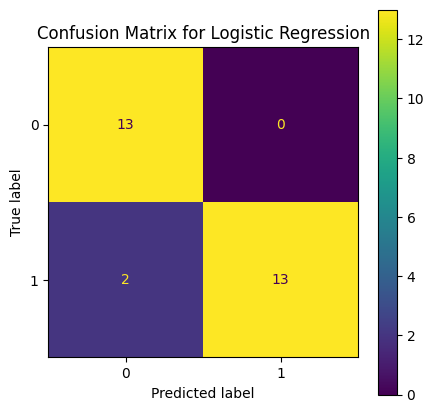

In [20]:
conf_mat(lrc_results, "Confusion Matrix for Logistic Regression")

In [21]:
lrc_test_acc = lrc.score(test_feat[:, 0:-1], test_feat[:, -1].astype(np.int64))
print(f"Logistic Regression Test Accuracy: {lrc_test_acc:.2f}")

Logistic Regression Test Accuracy: 0.94


# Adaboost

In [22]:
adab = AdaBoostClassifier(n_estimators=100, random_state=rnd_val)

adab_results = kcross_val(adab, train_feat)

In [23]:
naive_adab = naive_model()  # Naive model for the Adaboost validation data
naive_acc = naive_adab.score(adab_results["labels"])  # Naive accuracy

In [24]:
print(f"Model Validation accuracy = {adab_results['acc']}")
print(f"Naive accuracy = {naive_acc}")

Model Validation accuracy = 0.9259259259259259
Naive accuracy = 0.4074074074074074


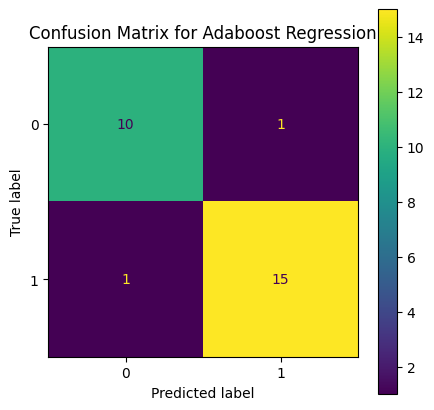

In [25]:
conf_mat(adab_results, "Confusion Matrix for Adaboost Regression")

In [26]:
adab_test_acc = adab.score(test_feat[:, 0:-1], test_feat[:, -1].astype(np.int64))

print(f"Adaboost Test Accuracy: {adab_test_acc}")

Adaboost Test Accuracy: 0.9375
